# Exploration 09

# 모듈 불러오기

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# Step 1. 실험환경 Set-up

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [ ]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train: ',len(train_filenames))
print('test: ',len(test_filenames))
print('validation: ',len(val_filenames))

train:  5216
test:  624
validation:  16


validation이 너무 적기 때문에, train에서 가져옵니다.

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(34)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


정상 이미지/폐렴 이미지 수 확인

In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person845_virus_1489.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1493_bacteria_3896.jpeg


파일 경로에 정상/폐렴 이미지 개수 세기

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1095
Pneumonia images count in training set: 3090


mini batch로 작업하기 위해 tf.data 인스턴트 만들기

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train / validation셋 개수 다시 확인

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


라벨 데이터를 만들어주는 함수 만들기

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈도 통일시키고, GPU의 효율성을 위해 사이즈를 줄이는 함수를 만듭니다.

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train / validation 데이터셋을 만듭니다.

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# AUTOTUNE 은, 가용한 CPU를 기반으로, 적절한 스레드의 개수를 지정해준다고 합니다.

이미지 리자이즈가 잘 되었는지, 라벨이 잘 들어갔는지 확인

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


테스트 셋도 만들고, 개수도 확인

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프 라인을 사용하여 데이터를 효율적으로 사용할 수 있도록 해준다.
- shufle()을 사용하여 고정 크기 버퍼를 유지하고, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat()을 사용하여, 여러번 데이터셋을 자동으로 사용할 수 있게함
- batch()를 을 사용하여 BATCH_SIZE에서 정한 배치로 주어줌
- prefetch()를 사용하여 학습데이터를 나눠서 읽어, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 GPU에서 준비할 수 있어, 리소스의 유후 상태를 줄일 수 있다.

# Augmentation

In [ ]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    # ds = ds.map(
    #         augment,       # augment 함수 적용
    #         num_parallel_calls=2
    #     )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#Step 3. 데이터 시각화

show_batch()함수를 이용하여 결과 사진을 봅니다.
- 데이터를 보기위해 train에 있는 batch중 첫 번째 배치를 추출합니다.
- 추출된 배치를 image, label 데이터셋으로 나눕니다.

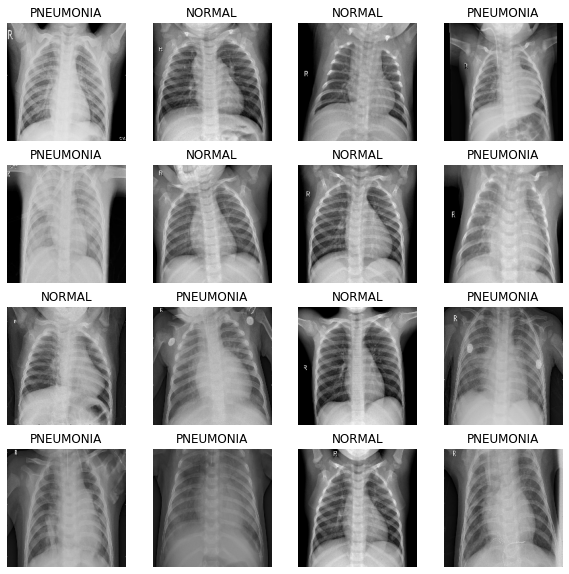

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

먼저, Convolution block을 만듭니다.
conv_block()구성은 Convolution을 두번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해경합니다. 그리고 Max Pooling을 합니다.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block은 아래와 같이 만듭니다.

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

한 라벨이 너무 많으면(imbalance) 좋지 않으므로, Weight balancing을 사용한다.
- Weight balncing은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss값을 갖도록 가중치를 부여하는 방법.
---
- 아래 코드에서 Weight_for_0은 'Nomal'이미지에 사용할 weight
- Weight_for_1은 'Pneumonia' 이미지에 사용 할 weight을 세팅.
-  weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례 하도록 설정됩니다.

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 0.68


# Step 6. 모델 훈련

- GPU를 사용할 것이기 때문에, GPU선택
- 이미지 라벨이 2개 뿐이므로, "binary_cross entropy" loss를 사용.
- optimizer 로 'adam'을 사용
- 성과에 측정하기 위한 metrics로 'accuracy', 'precision', 'recall'을 사용.

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델 fit하기

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 187ms/step - loss: 0.2434 - accuracy: 0.9001 - precision: 0.9714 - recall: 0.8911 - val_loss: 0.6476 - val_accuracy: 0.7567 - val_precision: 0.7567 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1759 - accuracy: 0.9303 - precision: 0.9761 - recall: 0.9282 - val_loss: 1.7211 - val_accuracy: 0.7577 - val_precision: 0.7577 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1465 - accuracy: 0.9454 - precision: 0.9828 - recall: 0.9426 - val_loss: 0.3746 - val_accuracy: 0.8202 - val_precision: 0.8080 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1219 - accuracy: 0.9557 - precision: 0.9850 - recall: 0.9547 - val_loss: 0.0798 - val_accuracy: 0.9731 - val_precision: 0.9774 - val_recall: 0.9873
Epoch 5/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1047 - accura

# Step 7. 결과 확인과 시각화

그래프로 에포크마다 변화 확인

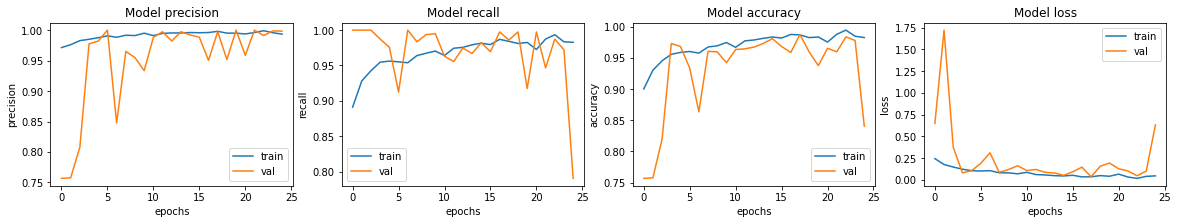

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

미니배치 사용으로 인해, validation 그래프가 들쑥 날쑥 하다.

모델 평가를 위해 loss, accuracy, precision, recall 값 출력

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 0.6587 - accuracy: 0.8782 - precision: 0.9385 - recall: 0.8615
Loss: 0.6586952209472656,
Accuracy: 0.8782051205635071,
Precision: 0.9385474920272827,
Recall: 0.8615384697914124


# 회고

## 이번 프로젝트를 하며 어려웠던 점
#### 이번 프로젝트를 하며 의료용 데이터 라는 점이 가장 어렵게 느껴졌습니다.
- 아무래도 의료용 데이터라는 점에서, 노드에서 설명했듯 augmentation 기법을 사용하는데에도 함부러 사용하지도 못하였고, 또한 의료지식이 없으니 제공된 폐렴 샘플사진과 정상 샘플사진을 확인해 보아도 좋은 데이터인지 아닌지, agumentation을 하였을 때 변화되는 부분에 대해 영향을 미칠지 안미칠 지에 관한 도메인 지식이 부족하였기에, 이미지를 활용한 데이터임에도 이미지를 분석할 수 없다는 점이 제한적으로 느껴졌습니다.

## 프로젝트를하며 알아낸 점 혹은 모호한 점
#### 모델링을 할 때 variance shift를 억제하는 Normalization과 이를 유발하는 Dropout을 동시에 사용하는것이 금기시 되는 이유가 있다는것을 알아내었습니다.
- 아래 설명하듯 다양한 방법들에서는 정확도를 85%를 넘지 못하였는데, 결국 Dropout을 제거하였더니 87%가 넘는다는 점에서 이 부분이 이번 실습의 킥이 아니었나 생각하였습니다. 라고 작성을 하였는데, 모델을 여러번 돌려보니 단지 단 한번 운이 좋았던 것으로 알게되었습니다. 때문에 생각보다 학습의 우연도에 대한 폭이 크구나를 다시한번 알게 되었습니다.

#### 하지만, 아직 관련 논문을 읽지 않았기에 이게 단순 우연히 학습이 잘 되어 정확도가 높게 나온것이 아닐까? 하는 모호함이 들었습니다.
- 그렇다면 학습률에 대한 폭이 큰 이유는 무엇일까? 하는 근본적인 문제에 고민하게 되었습니다. 아주 미세한 차이가 난다고 하면 그럴 수 있다고 생각 할 수 있는데, 어떨 때에는 76%가 나오고, 어떤 때에는 87%가 나오는 10%가 넘는 폭에 대해 궁금하게 되었습니다.

#### 제가 판단한 원본 데이터가 가장 좋은 영향을 주었을 것이다 하는 가설이 맞는지 모호합니다.
- 아래 쓰였듯, augmentation 부분에서, 우선 좌우 반전은 정확도에 큰 영향을 미지지 않았을 뿐 아니라, 좌우반전, 혹은 rotated, zoomed 등 폐렴을 구분하는 데이터 로써 훼손한다고 판단하여 결국 하지 않았는데, 이게 맞는지, 그게 아니라면, 어떤 방법들이 가장 효과적 이었을지에 대한 모호함이 남아있습니다.

## 루브릭 평가 지표를 맞추기 위해 시도한 것들.

### 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
- 시각화를 통하여, train셋과 validation 셋이 점점 안정을 찾아 가는 것을 확인하였습니다. validation 셋이 다소 들숙 날숙한 느낌을 주곤 하지만, 그 에 대한 폭 역시도 점점 줄어들고 있는 모습을 확인할 수 있습니다.

### Regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
#### Dropout을 뺀 모델의 결과:
- 우선적으로 아무것도 건들지 않는 노드 상태에서 Regularization 중 "Dropout"을 먼저 제거 하여 모델을 형성 한 뒤 학습을 시켜보았습니다. 우연한 결과로 지금까지 했던 학습 중 가장 높은 정확도인 87%가 나왔습니다. 하지만 다른 모델들도 여러번 돌려 보았지만 저정도 높은 수치는 나오지 않았기 때문에, 뺸 결과가 가장 성능이 좋다고 판단하였습니다.

##### Dropout을 넣고, BatchNormalization을 뺀 모델의 결과
- 정확도가 72%로 급격하게 떨어졌습니다. 이는, 폐렴이미지를 학습할 때에는 BatchNormalization 기법만 사용하는 것 보다는, 두 가지를 동시에 사용하는것이 좋고, 혹은 Dropout만을 사용하는것이 가장 성능에 적합하다는 것을 할았습니다.

#### augmentation 기법 사용
- augmentation의 경우에 많은 조사가있었고, 결국 하지 않기로 하였습니다.. 우선 노드에서 참고용으로 알려준 좌우 반전 같은 경우에는, 노드 9-4 에서 말해주었듯, 세균성 폐렴의 경우에는 일반적으로 오른쪽 상부 엽에 나타난다고 하였기 때문에, 좌우를 반전시키게 된다면 반대 방향에 세균성 폐렴이 발견 되기 때문에 잘못된 학습을 할 가능성이 있다고 생각하였습니다. 실제 모델을 돌려본 결과로는, 좌우반전을 한것과 하지 않은 데이터의 정확도 차이는 나타나지 않았습니다. 그 중 그나마 가장 기존 자료를 해치지 않는 선에서 쓸 수 있는 augmentation 기법이 무엇이 있을까 생각을 해보았는데, 약 10도 미만으로 하는 rotated, 아주 미세하게 하는 zoomed 정도를 생각하였습니다. 하지만 시도해보려고 하였으나, rotated 을 하게되면 사라진 값, 혹은 생긴 값에 대해 검정으로 모두 채워 넣는다고 해도 결국 그 값이 해당 데이터를 훼손하는 일이라 판단하였습니다. zoomed 역시도 마찬가지로, 원래의 데이터에서 헤칠 수 있는 문제라고 판단하여 개인적으로 원본데이터를 그대로 사용하는것이 가장 적합하다는 판단이 들어 결국에 사용하지 않기로 하였습니다.

### Accuracy 기준 85%에 도달하였다.
- 처음 생각한 85% 를 넘기기 위해 가장 중요한 요소는 augmentation이라고 생각했습니다. 때문에 할 수 있는 방법들을 찾아보았지만, 정확도에 영향을 미치지는 못하였습니다. 위에 설명했듯, 정확도에 큰 영향을 미치지 않는다면, 원본 데이터를 넣는것이 가장 옳다고 판단하여 원본데이터를 넣은체로 하이퍼 파라미터 값을 바꾸어 보았습니다. 우선 epoch 값을 오버피팅이 시작되는 지점에서로 바꾸어 보았지만, 매번 학습할 때 마다 달라지기에, 기본 실습에서 사용하였던 25가 가장 적합하다고 판단하였습니다. 또한 Batch_size 도 바꾸어 보았지만, 8일때, 32일때, 64일때 모두 80%도 넘지 못하는값, 즉 16일 때보다도 못한 값밖에 나오지 않아 이역시도 기본 실습에서 사용한 16으로 두었습니다. 다음으로는 optimizer 역시도 RMSprop 으로도 바꾸어 보았지만 성능이 개선되지 않았기에 다시 실습때 사용한 adam 으로 설정하였습니다. 이 모든 실험을 해 보았을때, 가장 높은 값이 82%가 나왔었지만, 85%에는 미치지 못하는 값 이었습니다. 그러던 중 위에 설명 한 Dropout을 제외한 체 CNN모델링을 설계하여 fit 하였더니, 최초로 85%가 넘는값인 87%가 나왔습니다. LMS에서 제공해 준 관련 논문을 읽지는 못하였지만, 아마 이 부분이 이번 실습의 킥이 아니었나 싶기에, 시간날때 틈틈히 그 논문에 대해 볼 예정입니다.

## 루브릭 평가 관련 지표를 달성하지 못했을 때, 이유에 관한 추정.
- 개인적인 판단으로 인해 augmentation을 사용 하지 않기로 하여 원본 데이터 만으로 사용한 것이 루브릭 평가 관련 지표를 달성하지 못한 이유가 되지 않았을 까하고 추측해봅니다. 결국에 학습하기에 아주 충분한 데이터가 아니기 때문에 augmentation을 사용하는 것이 학습에 정확도는 올려줄 것이다 라는 가설은 이해했지만, 도메인 지식이 부족한 상태에서 함부러 데이터 이미지를 건드는것이 적합하지 못하다고 판단하였습니다.

## 자기다짐
- 항상 Exploration을 하며 제가 추측하고 생각했던 것들 과는 늘 다른 결과를 보이는 듯 합니다. 때문에 항상 많이 배우는 것 같습니다. 제가 가장 큰 효과를 보았다고 말할 수 있는 부분인, "모델링을 할 때 variance shift를 억제하는 Normalization과 이를 유발하는 Dropout을 동시에 사용하는것이 금기시 되는 이유"에 관한, 혹은 성능향상에 도움이 된 사례 같은 논문을 읽어 내어 이번 노드의 학습 결과가 올라간 점에 대해 공부하고 싶었지만, 아직 논문을 읽는데에 익숙하지 않아서 우선 읽지 않았습니다. 하지만 이번 실습에 제게 가장 좋은 결과를 안겨주었기 때문에, 시간 날때 마다 틈틈히 반드시 읽어보아야 겠다는 생각을 합니다.